In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib as mlp
import matplotlib.pyplot as plt
#from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from sklearn import metrics
import math
from sklearn.metrics import mean_squared_error
sns.set_theme()

from sklearn.cluster import KMeans

# import dataset
dfPhiladelphia = pd.read_csv("data/tmp/dfPhiladelphia.csv.zip")
dfPhiladelphia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622850 entries, 0 to 622849
Data columns (total 31 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   start_date                              622850 non-null  object 
 1   end_date                                622850 non-null  object 
 2   start_time_hourly                       622850 non-null  int64  
 3   end_time_hourly                         622850 non-null  int64  
 4   start_station_id                        622850 non-null  int64  
 5   end_station_id                          622850 non-null  int64  
 6   bike_id                                 622850 non-null  int64  
 7   start_latitude                          622850 non-null  float64
 8   start_longitude                         622850 non-null  float64
 9   end_latitude                            622850 non-null  float64
 10  end_longitude                           6228

In [2]:
dfPhiladelphia['tripduration_min'] = dfPhiladelphia.apply(lambda row: round(row["tripduration_sec"]/60,0), axis=1)

In [3]:
dfPhiladelphia_clu = dfPhiladelphia[['start_time_hourly','tripduration_min',"distance (km)"]]
dfPhiladelphia_clu

,start_time_hourly,tripduration_min,distance (km)
0,0,8.0,1.485913
1,0,7.0,1.376549
2,1,13.0,2.133107
3,1,9.0,1.367935
4,1,12.0,2.044202
...,...,...,...
622845,23,12.0,1.471507
622846,23,46.0,0.194816
622847,23,4.0,0.587019
622848,0,7.0,1.575003


In [4]:
dfPhiladelphia_clu = dfPhiladelphia_clu[(dfPhiladelphia_clu['distance (km)'] < dfPhiladelphia_clu['distance (km)'].quantile(0.90))]
dfPhiladelphia_clu = dfPhiladelphia_clu[(dfPhiladelphia_clu['tripduration_min'] < dfPhiladelphia_clu['tripduration_min'].quantile(0.95))]

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dfPhiladelphia_clu)
dfPhiladelphia_clu_scaled = scaler.transform(dfPhiladelphia_clu)
X_scaled_df = pd.DataFrame(dfPhiladelphia_clu_scaled, columns=dfPhiladelphia_clu.columns, 
                           index=dfPhiladelphia_clu.index)
X_scaled_df.head()

,start_time_hourly,tripduration_min,distance (km)
0,-2.845500,-0.476828,0.096480
1,-2.845500,-0.638513,-0.085144
2,-2.644133,0.331600,1.171294
3,-2.644133,-0.315142,-0.099450
4,-2.644133,0.169914,1.023648


In [6]:
clusters = []
losses = []

for k in range(20):
    model = KMeans(n_clusters=k+1,n_init=1)
    model.fit(dfPhiladelphia_clu)
    clusters.append(k+1)
    losses.append(model.inertia_)

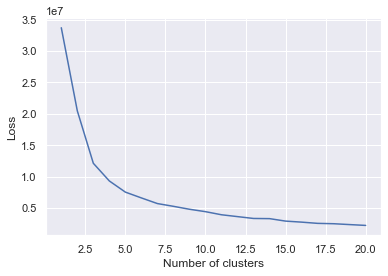

In [7]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

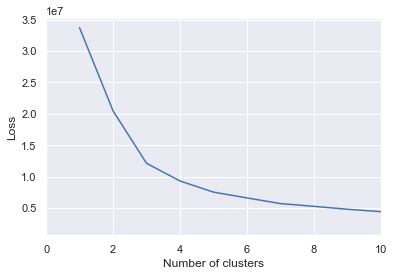

In [8]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])
plt.show()

In [9]:
kmean = KMeans(n_clusters=5,init='k-means++', random_state=42)

In [10]:
kmean.fit(dfPhiladelphia_clu)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=42)

In [11]:
Clusters = kmean.predict(dfPhiladelphia_clu)

In [12]:
dfPhiladelphia_clu.loc[:, ['cluster_number']] = Clusters
dfPhiladelphia_clu

,start_time_hourly,tripduration_min,distance (km),cluster_number
0,0,8.0,1.485913,2
1,0,7.0,1.376549,2
2,1,13.0,2.133107,0
3,1,9.0,1.367935,2
4,1,12.0,2.044202,0
...,...,...,...,...
622844,23,13.0,1.471507,4
622845,23,12.0,1.471507,4
622847,23,4.0,0.587019,1
622848,0,7.0,1.575003,2


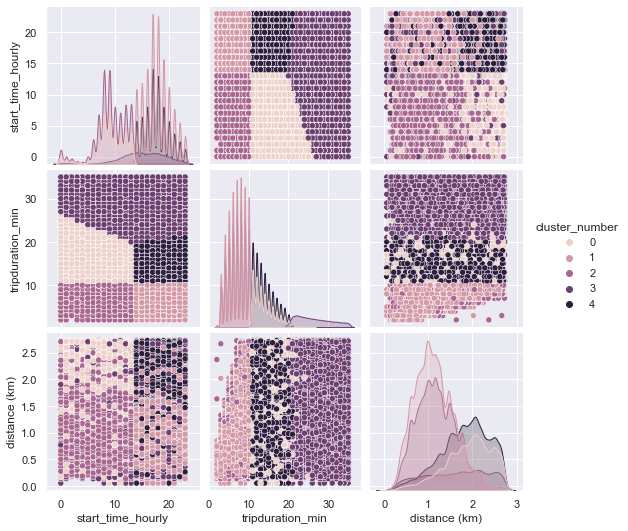

In [13]:
sns.pairplot(data=dfPhiladelphia_clu, hue = 'cluster_number')

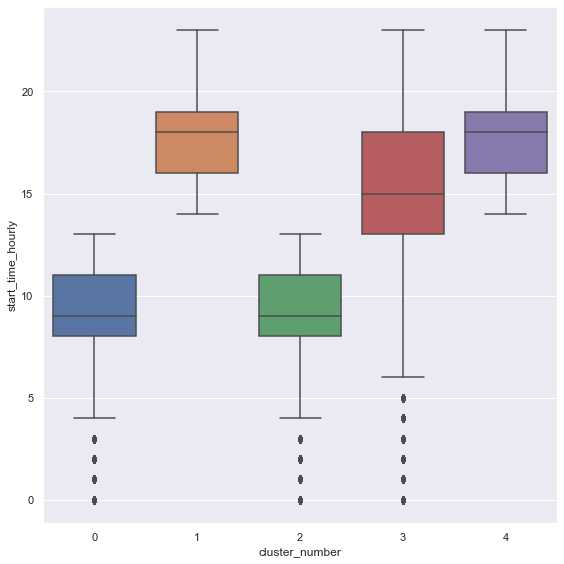

In [14]:
fig = plt.figure(figsize=(8, 8))
sns.boxplot(y=dfPhiladelphia_clu["start_time_hourly"], x = dfPhiladelphia_clu['cluster_number'])
plt.tight_layout()

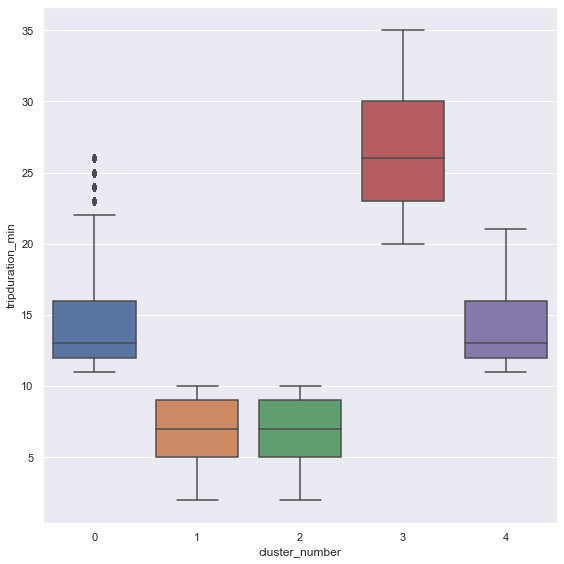

In [15]:
fig = plt.figure(figsize=(8, 8))
sns.boxplot(y=dfPhiladelphia_clu["tripduration_min"], x = dfPhiladelphia_clu['cluster_number'])
plt.tight_layout()

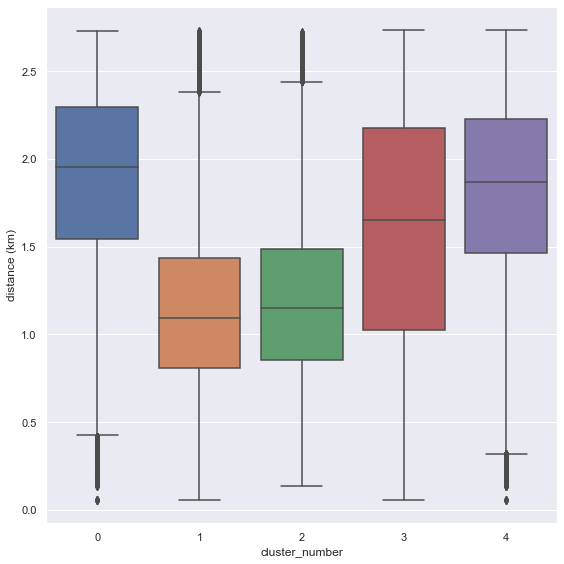

In [16]:
fig = plt.figure(figsize=(8, 8))
sns.boxplot(y=dfPhiladelphia_clu["distance (km)"], x = dfPhiladelphia_clu['cluster_number'])
plt.tight_layout()

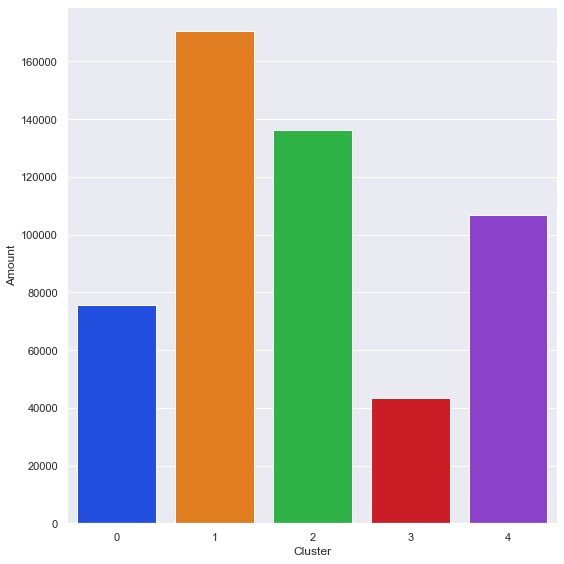

In [17]:
fig = plt.figure(figsize=(8, 8))
ax = sns.countplot(x="cluster_number", data=dfPhiladelphia_clu, palette="bright")
ax.set_xlabel("Cluster")
ax.set_ylabel("Amount")
fig.tight_layout()

In [18]:
dfPhiladelphia_loc_cluster = dfPhiladelphia[['start_latitude',
                                             'start_longitude','numOfRentedBikesHourlyStationDependent']]

In [19]:
dfPhiladelphia_loc_cluster

,start_latitude,start_longitude,numOfRentedBikesHourlyStationDependent
0,39.94509,-75.142500,1
1,39.94733,-75.144030,1
2,39.97195,-75.134450,1
3,39.96716,-75.170010,1
4,39.95081,-75.169530,1
...,...,...,...
622845,39.95273,-75.159790,3
622846,39.96207,-75.141113,1
622847,39.94019,-75.166910,1
622848,39.94732,-75.156950,1


In [20]:
dfPhiladelphia_loc_cluster = dfPhiladelphia_loc_cluster.groupby(['start_latitude', 'start_longitude'], 
                                        as_index=False)['numOfRentedBikesHourlyStationDependent'].sum()
dfPhiladelphia_loc_cluster

,start_latitude,start_longitude,numOfRentedBikesHourlyStationDependent
0,39.889940,-75.176790,663
1,39.893070,-75.171677,143
2,39.896290,-75.175140,628
3,39.904710,-75.173400,1761
4,39.920830,-75.170330,4649
...,...,...,...
142,39.987170,-75.174770,383
143,39.987709,-75.180519,62
144,39.988370,-75.187010,709
145,39.991190,-75.179750,911


In [22]:
clusters = []
losses = []

for k in range(20):
    model = KMeans(n_clusters=k+1,n_init=1)
    model.fit(dfPhiladelphia_loc_cluster)
    clusters.append(k+1)
    losses.append(model.inertia_)

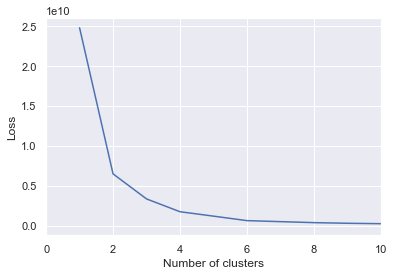

In [23]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])
plt.show()

In [24]:
kmeans = KMeans(
    init="random",
    n_clusters=4,
    random_state=42
)

In [25]:
kmeans.fit(dfPhiladelphia_loc_cluster)
# save results
labels = kmeans.labels_

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [26]:
dfPhiladelphia_loc_cluster['cluster'] = labels
# display the number of mamber each clustering
dfPhiladelphia_loc_cluster.reset_index(inplace=True, drop = True)

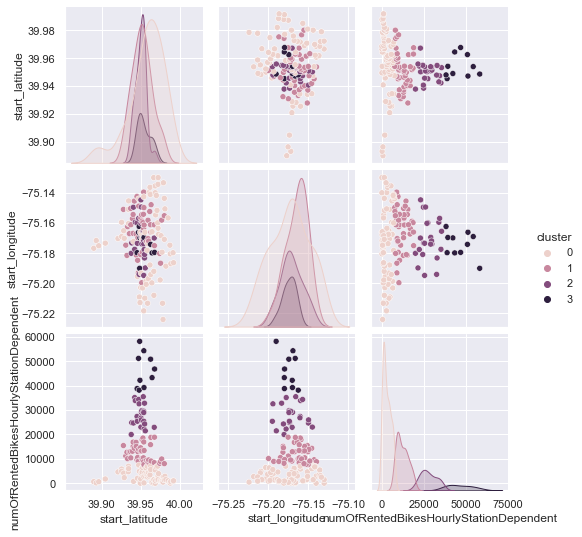

In [27]:
sns.pairplot(data=dfPhiladelphia_loc_cluster, hue = 'cluster')

In [28]:
import folium

colors = ['blue', 'orange', 'green', 'red', 'purple', 'darkred', \
     'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', \
     'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', \
     'black', 'lightgray', 'red', 'blue', 'green', 'purple', \
     'orange', 'darkred', 'lightred', 'beige', 'darkblue', \
     'darkgreen', 'cadetblue', 'darkpurple','pink', 'lightblue', \
     'lightgreen', 'gray', 'black', 'lightgray' ]
    

cluster_color = colors[0:5]

lati = dfPhiladelphia_loc_cluster['start_latitude']
longi = dfPhiladelphia_loc_cluster['start_longitude']
cluster_for_color = dfPhiladelphia_loc_cluster['cluster']


map=folium.Map(location = [39.94509,-75.14250],tiles="Stamen Toner")

for i in range(len(dfPhiladelphia_loc_cluster)):
    folium.Circle([lati[i],longi[i]], fill = True, color = colors[cluster_for_color[i]], radius= 20).add_to(map)


map

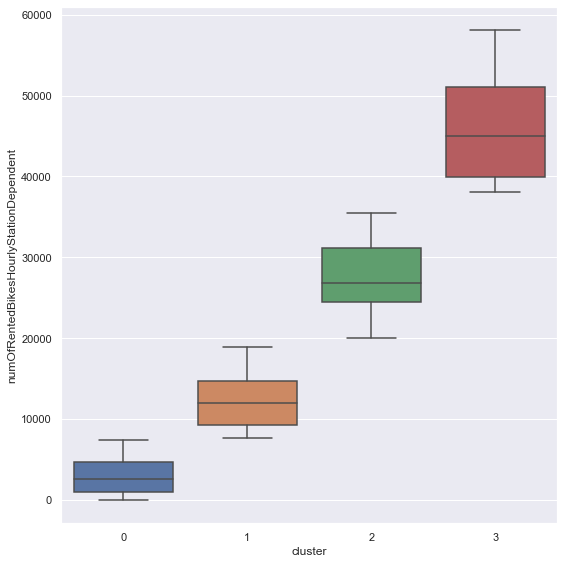

In [29]:
fig = plt.figure(figsize=(8, 8))
sns.boxplot(y=dfPhiladelphia_loc_cluster["numOfRentedBikesHourlyStationDependent"], 
            x = dfPhiladelphia_loc_cluster['cluster'])
plt.tight_layout()

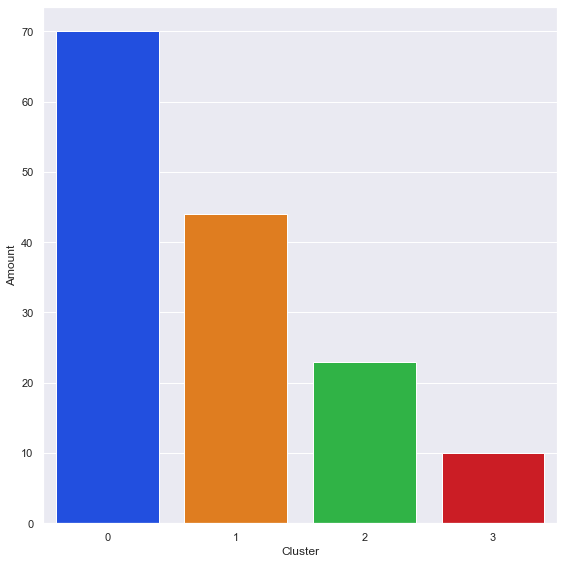

In [30]:
fig = plt.figure(figsize=(8, 8))
ax = sns.countplot(x="cluster", data=dfPhiladelphia_loc_cluster, palette="bright")
ax.set_xlabel("Cluster")
ax.set_ylabel("Amount")
fig.tight_layout()

# 3. Cluster Analysis

We use a **Cluster Analysis** in order to identify clusters of 
 - *trip types* and/or
 - *customer types*
 
based on the bike rental demand patterns.

Additionally we are interested, whether we can *label these clusters* and *cluster the locations* based on their demand pattern.

## 3.1 Data Prep and Scaling

## 3.2 Principal Component Analysis (PCA)
- for dimensionality reduction

## 3.3 Clustering with Dendrogram